In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
import scipy.stats as st
import seaborn as sns
import matplotlib.cm as mplcm
import matplotlib.colors as colors

/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2019.10-py3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
"""
NOTE: FIPS codes are 5 digit strings for each county in the US
The first two digits are for the state (so each state has a two character code)
#and the last 3 are for the county, but all 5 are used to refer to the county

Virginia FIPS is 51
"""
#To convert between state name representations
state_to_stfips_path ="/project/biocomplexity/COVID-19_commons/2019-nCoV_stat-analyses/misc_data/stfips_to_state.csv"
state_to_stfips_df = pd.read_csv(state_to_stfips_path, header=None, dtype={"2":str})
state_to_stfips_df[2] = state_to_stfips_df[2].astype(str).str.zfill(2)
state_to_stfips = state_to_stfips_df.set_index(0)[2].to_dict()
abbr_to_stfips = state_to_stfips_df.set_index(1)[2].to_dict()

#To hold the population of each FIPS
fips_to_pop = pd.read_csv("/project/biocomplexity/COVID-19_commons/2019-nCoV_stat-analyses/misc_data/co-est2019-alldata.csv", encoding="latin-1")
fips_to_pop["fips"] = fips_to_pop.STATE.astype(str).str.zfill(2) + fips_to_pop.COUNTY.astype(str).str.zfill(3).replace("000", "")
fips_to_pop = fips_to_pop.set_index("fips")["POPESTIMATE2019"].to_dict()

#Add some terrotory populations
fips_to_pop["60"] = 55312
fips_to_pop["66"] = 165768
fips_to_pop["69"] = 56882
fips_to_pop["72"] = 2849276
fips_to_pop["78"] = 106977

In [4]:
"""
To get state level cases
"""
state_level_cases = pd.read_csv("/project/biocomplexity/COVID-19_commons/data/NyTimes/us-states.csv", parse_dates=["date"], dtype={"fips":str})

state_level_cases_cumulative = state_level_cases.pivot(index="date", columns="fips", values="cases")
state_level_cases_incidence = state_level_cases.pivot(index="date", columns="fips", values="cases").diff()

In [5]:
"""
To get county level cases
"""
county_level_cases = pd.read_csv("/project/biocomplexity/COVID-19_commons/data/NyTimes/us-counties.csv", parse_dates=["date"], dtype={"fips":str})

county_level_cases_cumulative = county_level_cases.pivot_table(index="date", columns="fips", values="cases", aggfunc=np.mean)
county_level_cases_incidence = county_level_cases.pivot_table(index="date", columns="fips", values="cases", aggfunc=np.mean).diff()

In [6]:
"""
To convert, e.g. state, cases to cases per 100k population
"""
state_level_cases_incidence_per_100k = state_level_cases_incidence.apply(lambda col: col / (fips_to_pop[col.name] / 100000), axis=0)

In [7]:
"""
To get state level variant samples (by FIPS). One line per sample from GISAID and NCBI, after deduplication of submissions
"""
state_level_variants = pd.read_csv("/project/biocomplexity/COVID-19_commons/data/variants/variant_samples_by_state.csv", parse_dates=["date", "submission_date"], dtype={"state":str})

In [8]:
"""
To get VA variant prevalence, and number of samples, by fortnight
"""
va_variants = state_level_variants[state_level_variants.state == "51"]
va_variants["count"] = 1
va_variants = va_variants.pivot_table(index="date", columns="variant", values="count", aggfunc=sum)
va_variants = va_variants.resample("14D").sum().replace(0, np.nan)
va_variant_prevalence = va_variants.apply(lambda col: col / va_variants.sum(axis=1), axis=0)
va_samples = va_variants.sum(axis=1)

/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2019.10-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Text(0.5, 1.0, 'Min Prevalence Detectable')

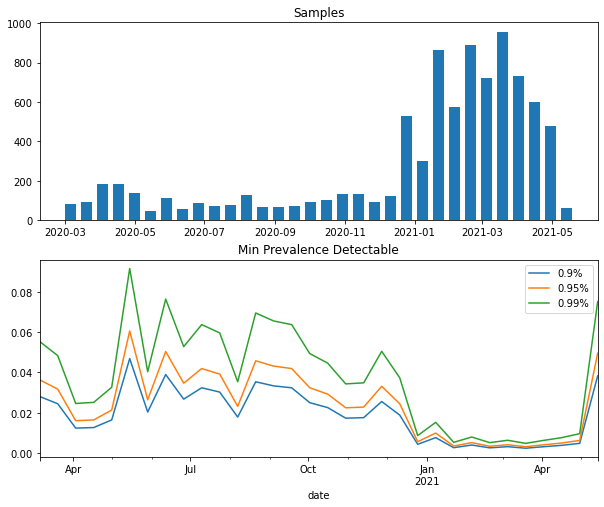

In [9]:
"""
Plot the number of samples, and minimum prevalence detectable with that sample count (Phi from the UT site)
"""

def apply_confidence_bound(col, prob):
    return 1 - (1 - prob)**(1/col)

sample_bounds = pd.DataFrame(va_samples, columns=["samples"])

for confidence in [0.9, 0.95, 0.99]:
    sample_bounds[f"{confidence}%"] = apply_confidence_bound(sample_bounds.samples, confidence)

fig, axs = plt.subplots(2, figsize=(10,8))

axs[0].bar(sample_bounds.index, sample_bounds.samples, width=10)
sample_bounds.drop(columns=["samples"]).plot(ax=axs[1])

axs[0].set_title("Samples")
axs[1].set_title("Min Prevalence Detectable")

### Montgomery and Fairfax Case Studies

In [10]:
def get_adaptive(path):
    adaptive = pd.read_csv(path, dtype={"id":str})

    adaptive.id = adaptive.id.str.zfill(5)
    adaptive = adaptive.set_index("id")
    adaptive.columns = [np.datetime64("2020-01-23") + np.timedelta64(c) for c in adaptive.columns]
    adaptive = adaptive.T
    adaptive = adaptive[[c for c in adaptive.columns.dropna()]]
    adaptive = adaptive.drop(columns=[c for c in adaptive.columns if "." in c or int(c) == 0])
    return adaptive

In [11]:
infections = "/sfs/qumulo/qproject/biocomplexity/pjp2b/devel/adaptive_SEIR/output_ensemble/v11_ensemble/projections_dev/2021-05-29/51/v1.8_i14_1w/Adaptive/Adaptive_infected_med.csv"
infections = get_adaptive(infections)

In [12]:
# ascertainment = pd.read_csv("/sfs/qumulo/qproject/biocomplexity/COVID-19_commons/data/ascertainment/CDC_ascertainment_with_6_month_waning-2021-06-01.csv", parse_dates=["date"], dtype={"fips":str})
# ascertainment[ascertainment.fips == "51"]

<AxesSubplot:xlabel='date'>

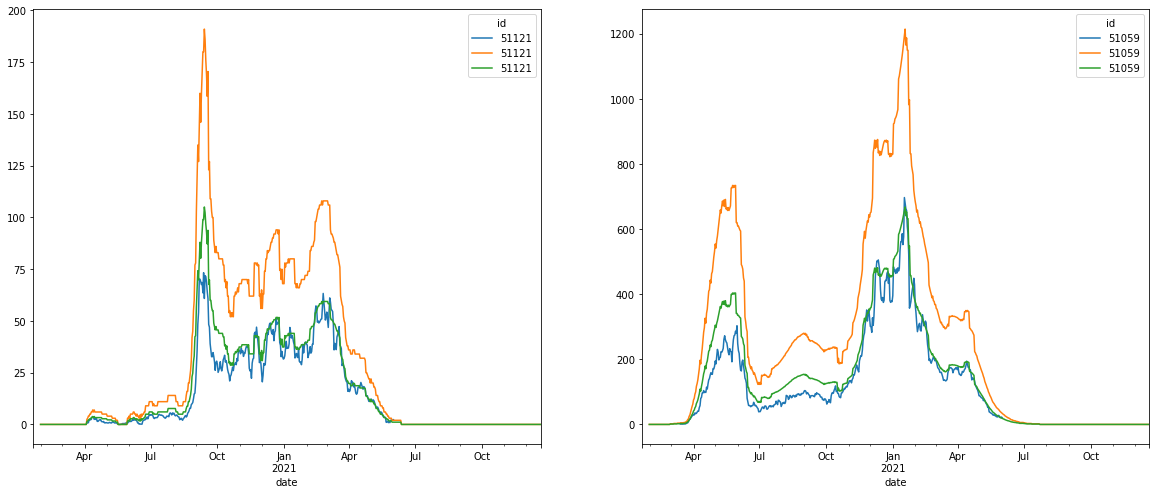

In [13]:
fairfax = "51059"
montgomery = "51121"
loc_map = {fairfax:"Fairfax", montgomery:"Montgomery"}

fairfax_cases = county_level_cases_incidence[[fairfax]]
montgomery_cases = county_level_cases_incidence[[montgomery]]

fig, axs = plt.subplots(1, 2, figsize=(20,8))
montgomery_cases.rolling(7).mean().plot(ax=axs[0], label="cases")
infections[[montgomery]].shift(7).plot(ax=axs[0], label="cases")
(infections[[montgomery]] * 0.55).shift(7).plot(ax=axs[0], label="cases")

fairfax_cases.rolling(7).mean().plot(ax=axs[1], label="cases")
infections[[fairfax]].shift(7).plot(ax=axs[1], label="cases")
(infections[[fairfax]] * 0.55).shift(7).plot(ax=axs[1], label="cases")

Wilson's interval is defined as 

$ p \approx \frac{n_S + \frac{1}{2}z^2}{n+z^2} \pm \frac{z}{n+z^2}\sqrt{\frac{n_Sn_F}{n} + \frac{z^2}{4}}$

so, a defined CI width $ W = \frac{2z}{n+z^2}\sqrt{\frac{n_Sn_F}{n} + \frac{z^2}{4}}$, where $n_S = p$ and $n_F = 1-p$

solving for $n$ gets the following solution (from quadratic formula) 

$ n = \frac{-(2z^2 - \frac{4z^2p(1-p)}{W^2}) + \sqrt{(2z^2 - \frac{4z^2p(1-p)}{W^2})^2 - 4(\frac{z^4}{W^2} - z^4)}}{2} $

In [108]:
"""
We want the number of samples needed to detect the variant and to estimate the prevalence within a 10% bounds
"""
def calculate_samples_to_detect(prevalence, confidence):
    return math.ceil( math.log(1 - confidence) / math.log(1  - prevalence) )

# def calculate_samples_to_estimate(prevalence, confidence, CI_percentage_one_direction):
#     alpha = (1 - confidence) / 2
#     z_score = st.norm.ppf(1 - alpha)
#     b_term = 2 * z_score ** 2 - 4 * ( z_score ** 2 / CI_percentage_one_direction ** 2 ) * prevalence * (1 - prevalence)
#     c_term = - ( z_score ** 4 - z_score ** 4 * CI_percentage_one_direction ** 2 ) / (CI_percentage_one_direction ** 2)
#     root_1 = (- b_term + (b_term ** 2 - 4 * c_term) ** (1/2) ) / 2
#     root_2 = (- b_term - (b_term ** 2 - 4 * c_term) ** (1/2) ) / 2
#     return math.ceil( max(root_1, root_2) )

def calculate_samples_to_estimate(prevalence, confidence, CI_percentage_one_direction, pop_size):
  
    alpha = (1 - confidence) / 2
    z_score = st.norm.ppf(1 - alpha)
    
    num = 4*pop_size*z_score*prevalence*(1-prevalence)
    denom = pop_size*CI_percentage_one_direction**2 - CI_percentage_one_direction**2 + 4*z_score*prevalence*(1-prevalence)
#     print(prevalence, confidence, CI_percentage_one_direction, pop_size, num / denom)
    
    return num / denom
    
calculate_samples_to_estimate(0.8, 0.95, 0.05, 87)

74.27011472539073

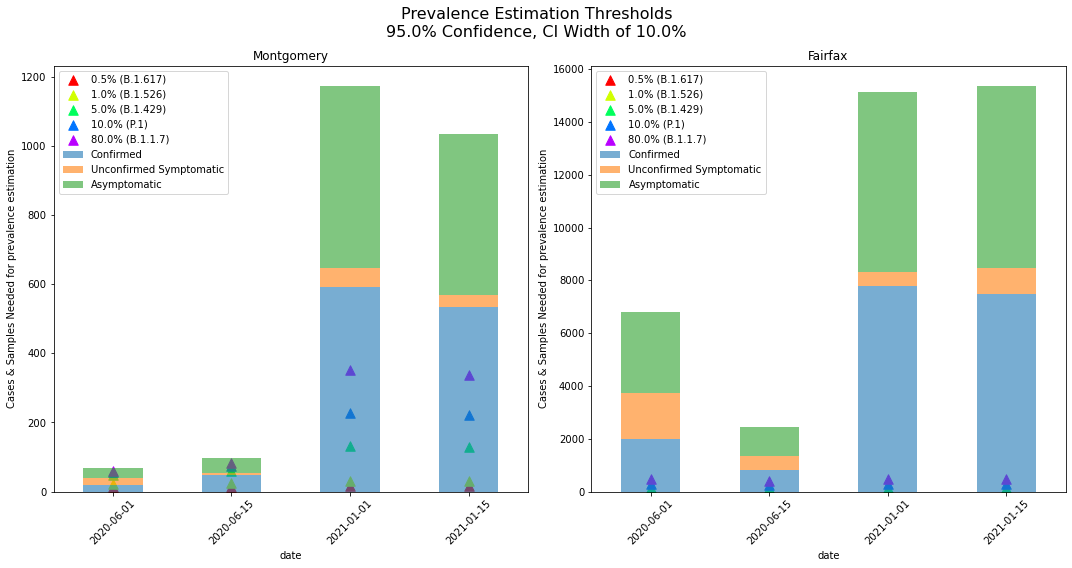

In [137]:
# location = montgomery
CI_tail = 0.05
confidence = 0.95
dates = ["2020-06-01", "2020-06-15", "2021-01-01", "2021-01-15"]
variant_prevalences = {"B.1.617":0.005, "B.1.526":0.01, "B.1.429":0.05, "P.1":0.1, "B.1.1.7":0.8}

values = "prevalence estimation" #"detection" or "prevalence estimation"
if values == "detection":
    cm = plt.get_cmap('tab10')
else:
    cm = plt.get_cmap('hsv')

cNorm  = colors.Normalize(vmin=0, vmax=len(variant_prevalences.keys()))
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
tab_variant_colors = [scalarMap.to_rgba(i) for i in range(len(variant_prevalences.keys()))]
fig, axs = plt.subplots(1, 2, figsize=(15,8))

# detection_summary_fig, detection_sumary_axs = plt.subplots(figsize=(10,8))
# estimation_summary_fig, estimation_sumary_axs = plt.subplots(1, 2, figsize=(15,8))

for ix, location in enumerate([montgomery, fairfax]):
    date_cases = []
    variant_info = []
    
    columns = ['date', 'location', 'variant', 'prevalence', 'detection_samples', 'estimate_samples', 'confidence', 'CI_tail', 'Confirmed', 'Symptomatic', 'Asymptomatic']
    for date in dates:
        date = np.datetime64(date)
        end_date = date + np.timedelta64(14, "D")
        Confirmed = county_level_cases_incidence[[location]].loc[date:end_date].sum().iloc[0]
        Symptomatic = infections[[location]].shift(7).loc[date:end_date].sum().iloc[0] * 0.55
        Asymptomatic = infections[[location]].shift(7).loc[date:end_date].sum().iloc[0] * 0.45    
        date_cases.append((date, location, Confirmed, Symptomatic, Asymptomatic))

        for variant, prevalence in variant_prevalences.items():
            detection_samples = calculate_samples_to_detect(prevalence, 0.95)
            estimate_samples = calculate_samples_to_estimate(prevalence, confidence, CI_tail, Symptomatic + Asymptomatic)
            variant_info.append((location, date, variant, prevalence, detection_samples, estimate_samples, confidence, CI_tail))

    date_df = pd.DataFrame.from_records(date_cases, columns = ["date", "location", "Confirmed", "Symptomatic", "Asymptomatic"])
    variant_df = pd.DataFrame.from_records(variant_info, columns = ['location', 'date', 'variant', 'prevalence', 'detection_samples', 'estimate_samples', 'confidence', 'CI_tail'])

    date_df.date = date_df.date.astype(str)
    date_df.Symptomatic = date_df.Symptomatic - date_df.Confirmed
    
    if values.lower() == "detection":
        fig_title = f"Detection Thresholds\n{confidence*100}% Confidence"
        variant_samples = variant_df.set_index("variant")["detection_samples"].to_dict()
    else:
        fig_title = f"Prevalence Estimation Thresholds\n{confidence*100}% Confidence, CI Width of {2 * CI_tail*100}%"
        variant_samples = variant_df.set_index("variant")["estimate_samples"].to_dict()
        
    ax = axs[ix]
    ax.set_prop_cycle(color=tab_variant_colors)

    date_df.set_index("date")[["Confirmed", "Symptomatic", "Asymptomatic"]].rename(columns={"Symptomatic":"Unconfirmed Symptomatic"}).drop_duplicates().plot(kind='bar', stacked=True, rot=45, ax=ax, alpha=0.6)
    
    if values.lower() != "detection":
        fig_title = f"Prevalence Estimation Thresholds\n{confidence*100}% Confidence, CI Width of {2 * CI_tail*100}%"
        for ix, variant in enumerate(variant_df.variant.unique()):
            df = variant_df[variant_df.variant == variant]
            ax.scatter(df.date.astype(str), df.estimate_samples, label=f"{variant_prevalences[variant]*100}% ({variant})", color = tab_variant_colors[ix], marker = "^", s=90)
    else:
        fig_title = f"Detection Thresholds\n{confidence*100}% Confidence"
        variant_samples = variant_df.set_index("variant")["detection_samples"].to_dict()
        
        ix=0
        
        for variant, detection in variant_samples.items():
#             print(tab_variant_colors[ix])
            ax.axhline(detection, label=f"{variant_prevalences[variant]*100}% ({variant})", color = tab_variant_colors[ix], linestyle = "-.")
            ix += 1

    ax.legend(loc="upper left")
    ax.set_ylabel(f"Cases & Samples Needed for {values}")
    ax.set_title(loc_map[location])
    
fig.suptitle(fig_title, fontsize=16)
plt.tight_layout()
plt.savefig(f"montgomery_fairfax_{values}.png", dpi=100, bbox_inches="tight", facecolor="white")

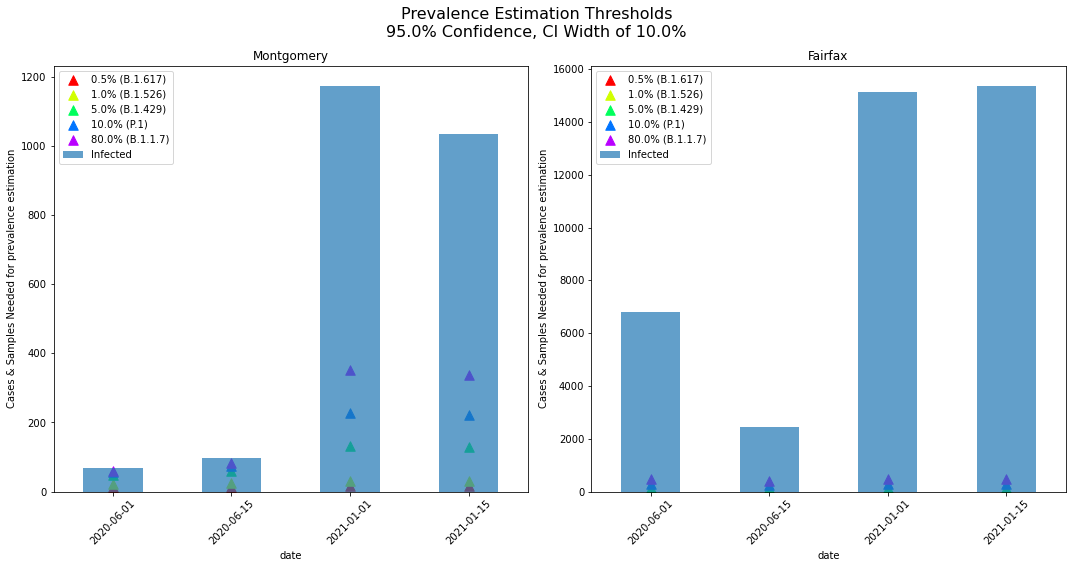

In [139]:
# location = montgomery
CI_tail = 0.05
confidence = 0.95
dates = ["2020-06-01", "2020-06-15", "2021-01-01", "2021-01-15"]
variant_prevalences = {"B.1.617":0.005, "B.1.526":0.01, "B.1.429":0.05, "P.1":0.1, "B.1.1.7":0.8}

values = "prevalence estimation" #"detection" or "prevalence estimation"
if values == "detection":
    cm = plt.get_cmap('tab10')
else:
    cm = plt.get_cmap('hsv')

cNorm  = colors.Normalize(vmin=0, vmax=len(variant_prevalences.keys()))
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
tab_variant_colors = [scalarMap.to_rgba(i) for i in range(len(variant_prevalences.keys()))]
fig, axs = plt.subplots(1, 2, figsize=(15,8))

# cm = plt.get_cmap('hsv')
# cNorm  = colors.Normalize(vmin=0, vmax=len(variant_prevalences.keys()))
# scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
# tab_variant_colors = [scalarMap.to_rgba(i) for i in range(len(variant_prevalences.keys()))]
# values = "prevalence estimation" #"detection" or "prevalence estimation"

# fig, axs = plt.subplots(1, 2, figsize=(15,8))
# detection_summary_fig, detection_sumary_axs = plt.subplots(figsize=(10,8))
# estimation_summary_fig, estimation_sumary_axs = plt.subplots(1, 2, figsize=(15,8))

for ix, location in enumerate([montgomery, fairfax]):
    date_cases = []
    variant_info = []
    
    columns = ['date', 'location', 'variant', 'prevalence', 'detection_samples', 'estimate_samples', 'confidence', 'CI_tail', 'Confirmed', 'Symptomatic', 'Asymptomatic']
    for date in dates:
        date = np.datetime64(date)
        end_date = date + np.timedelta64(14, "D")
        Confirmed = county_level_cases_incidence[[location]].loc[date:end_date].sum().iloc[0]
        Symptomatic = infections[[location]].shift(7).loc[date:end_date].sum().iloc[0] * 0.55
        Asymptomatic = infections[[location]].shift(7).loc[date:end_date].sum().iloc[0] * 0.45    
        date_cases.append((date, location, Confirmed, Symptomatic, Asymptomatic))

        for variant, prevalence in variant_prevalences.items():
            detection_samples = calculate_samples_to_detect(prevalence, 0.95)
            estimate_samples = calculate_samples_to_estimate(prevalence, confidence, CI_tail, Symptomatic + Asymptomatic)
            variant_info.append((location, date, variant, prevalence, detection_samples, estimate_samples, confidence, CI_tail))

    date_df = pd.DataFrame.from_records(date_cases, columns = ["date", "location", "Confirmed", "Symptomatic", "Asymptomatic"])
    variant_df = pd.DataFrame.from_records(variant_info, columns = ['location', 'date', 'variant', 'prevalence', 'detection_samples', 'estimate_samples', 'confidence', 'CI_tail'])

    date_df.date = date_df.date.astype(str)
    date_df.Symptomatic = date_df.Symptomatic - date_df.Confirmed
    
    if values.lower() == "detection":
        fig_title = f"Detection Thresholds\n{confidence*100}% Confidence"
        variant_samples = variant_df.set_index("variant")["detection_samples"].to_dict()
    else:
        fig_title = f"Prevalence Estimation Thresholds\n{confidence*100}% Confidence, CI Width of {2 * CI_tail*100}%"
        variant_samples = variant_df.set_index("variant")["estimate_samples"].to_dict()
        
    ax = axs[ix]
    ax.set_prop_cycle(color=tab_variant_colors)
    
    date_df["Infected"] = date_df.Confirmed + date_df.Symptomatic + date_df.Asymptomatic
    date_df.set_index("date")[["Infected"]].drop_duplicates().plot(kind='bar', stacked=True, rot=45, ax=ax, alpha=0.7)
    
    if values.lower() != "detection":
        fig_title = f"Prevalence Estimation Thresholds\n{confidence*100}% Confidence, CI Width of {2 * CI_tail*100}%"
        for ix, variant in enumerate(variant_df.variant.unique()):
            df = variant_df[variant_df.variant == variant]
            ax.scatter(df.date.astype(str), df.estimate_samples, label=f"{variant_prevalences[variant]*100}% ({variant})", color = tab_variant_colors[ix], marker = "^", s=90)
    else:
        fig_title = f"Detection Thresholds\n{confidence*100}% Confidence"
        variant_samples = variant_df.set_index("variant")["detection_samples"].to_dict()
        
        ix=0
        
        for variant, detection in variant_samples.items():
#             print(tab_variant_colors[ix])
            ax.axhline(detection, label=f"{variant_prevalences[variant]*100}% ({variant})", color = tab_variant_colors[ix], linestyle = "-.")
            ix += 1

    ax.legend(loc="upper left")
    ax.set_ylabel(f"Cases & Samples Needed for {values}")
    ax.set_title(loc_map[location])
    
fig.suptitle(fig_title, fontsize=16)
plt.tight_layout()
plt.savefig(f"montgomery_fairfax_{values}_Infected_only.png", dpi=100, bbox_inches="tight", facecolor="white")

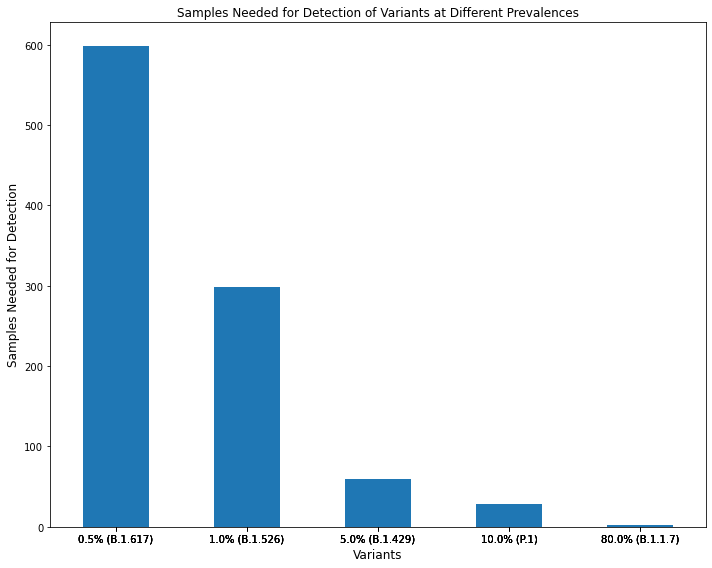

In [140]:
# location = montgomery
CI_tail = 0.05
confidence = 0.95
dates = ["2020-06-01", "2020-06-15", "2021-01-01", "2021-01-15"]
variant_prevalences = {"B.1.617":0.005, "B.1.526":0.01, "B.1.429":0.05, "P.1":0.1, "B.1.1.7":0.8}
cm = plt.get_cmap('tab10')
cNorm  = colors.Normalize(vmin=0, vmax=len(variant_prevalences.keys()))
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
tab_variant_colors = [scalarMap.to_rgba(i) for i in range(len(variant_prevalences.keys()))]
values = "detection" #"detection" or "prevalence estimation"

# main_fig, main_axs = plt.subplots(figsize=(10,8))

for ix, location in enumerate([montgomery, fairfax]):
    date_cases = []
    variant_info = []
    
    columns = ['date', 'location', 'variant', 'prevalence', 'detection_samples', 'estimate_samples', 'confidence', 'CI_tail', 'Confirmed', 'Symptomatic', 'Asymptomatic']
    for date in dates:
        date = np.datetime64(date)
        end_date = date + np.timedelta64(14, "D")
        Confirmed = county_level_cases_incidence[[location]].loc[date:end_date].sum().iloc[0]
        Symptomatic = infections[[location]].shift(7).loc[date:end_date].sum().iloc[0] * 0.55
        Asymptomatic = infections[[location]].shift(7).loc[date:end_date].sum().iloc[0] * 0.45    
        date_cases.append((date, location, Confirmed, Symptomatic, Asymptomatic))

        for variant, prevalence in variant_prevalences.items():
            detection_samples = calculate_samples_to_detect(prevalence, 0.95)
            estimate_samples = calculate_samples_to_estimate(prevalence, confidence, CI_tail, Symptomatic + Asymptomatic)
            variant_info.append((location, date, variant, prevalence, detection_samples, estimate_samples, confidence, CI_tail))

    date_df = pd.DataFrame.from_records(date_cases, columns = ["date", "location", "Confirmed", "Symptomatic", "Asymptomatic"])
    variant_df = pd.DataFrame.from_records(variant_info, columns = ['location', 'date', 'variant', 'prevalence', 'detection_samples', 'estimate_samples', 'confidence', 'CI_tail'])

    date_df.date = date_df.date.astype(str)
    date_df.Symptomatic = date_df.Symptomatic - date_df.Confirmed
    
    fig, ax = plt.subplots(figsize=(10,8))
    variant_df.plot(x="variant", y="detection_samples", kind="bar", ax=ax, legend=None, rot=0)
    ax.set_xticklabels([f"{variant_prevalences[i.get_text()]*100}%" + f" ({i.get_text()})" for i in ax.get_xticklabels()])
    ax.set_xlabel("Variants", fontsize=12)
    ax.set_ylabel("Samples Needed for Detection", fontsize=12)
    ax.set_title("Samples Needed for Detection of Variants at Different Prevalences", fontsize=12)
    break
    
#     if values.lower() == "detection":
#         fig_title = f"Detection Thresholds\n{confidence*100}% Confidence"
#         variant_samples = variant_df.set_index("variant")["detection_samples"].to_dict()
#     else:
#         fig_title = f"Prevalence Estimation Thresholds\n{confidence*100}% Confidence, CI Width of {2 * CI_tail*100}%"
#         variant_samples = variant_df.set_index("variant")["estimate_samples"].to_dict()
        
#     ax = axs[ix]
#     ax.set_prop_cycle(color=tab_variant_colors)

#     date_df.set_index("date")[["Confirmed", "Symptomatic", "Asymptomatic"]].rename(columns={"Symptomatic":"Unconfirmed Symptomatic"}).drop_duplicates().plot(kind='bar', stacked=True, rot=45, ax=ax, alpha=0.7)
    
#     if values.lower() != "detection":
#         fig_title = f"Detection Thresholds\n{confidence*100}% Confidence"
#         for ix, variant in enumerate(variant_df.variant.unique()):
#             df = variant_df[variant_df.variant == variant]
#             ax.scatter(df.date.astype(str), df.estimate_samples, label=f"{variant_prevalences[variant]*100}% ({variant})", color = tab_variant_colors[ix], marker = "^", s=90)
#     else:
#         fig_title = f"Prevalence Estimation Thresholds\n{confidence*100}% Confidence, CI Width of {2 * CI_tail*100}%"
#         variant_samples = variant_df.set_index("variant")["estimate_samples"].to_dict()
        
#         ix=0
        
#         for variant, detection in variant_samples.items():
# #             print(tab_variant_colors[ix])
#             ax.axhline(detection, label=f"{variant} ({variant_prevalences[variant]*100}%)", color = tab_variant_colors[ix], linestyle = "-.")
#             ix += 1

#     ax.legend(loc="upper left")
#     ax.set_ylabel(f"Cases & Samples Needed for {values}")
#     ax.set_title(loc_map[location])
    
# fig.suptitle(fig_title, fontsize=16)
plt.tight_layout()
plt.savefig(f"montgomery_fairfax_detection_summary_bar.png", dpi=100, bbox_inches="tight", facecolor="white")

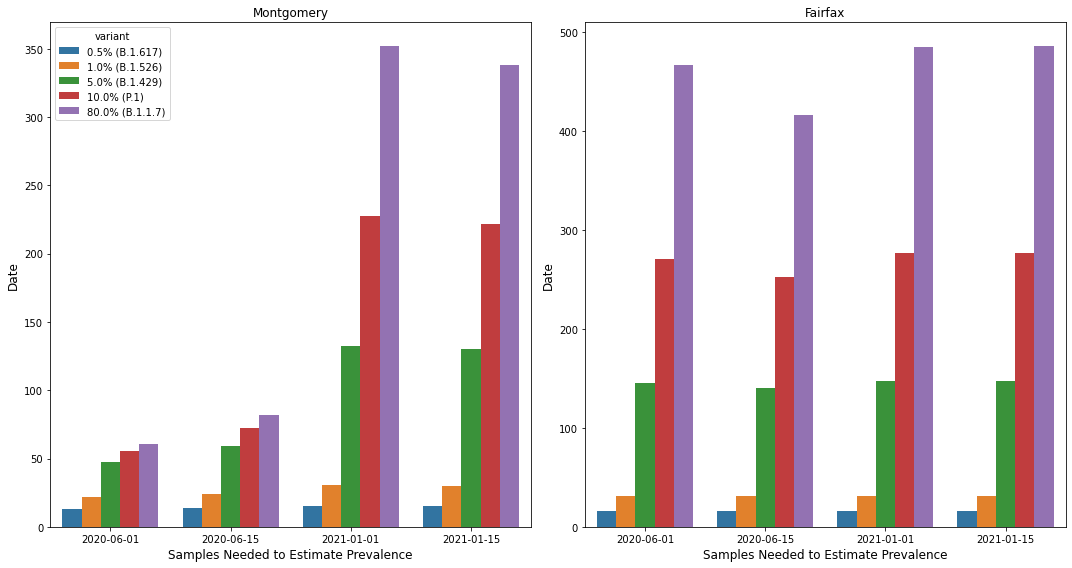

In [141]:
# location = montgomery
CI_tail = 0.05
confidence = 0.95
dates = ["2020-06-01", "2020-06-15", "2021-01-01", "2021-01-15"]
variant_prevalences = {"B.1.617":0.005, "B.1.526":0.01, "B.1.429":0.05, "P.1":0.1, "B.1.1.7":0.8}
cm = plt.get_cmap('tab10')
cNorm  = colors.Normalize(vmin=0, vmax=len(variant_prevalences.keys()))
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
tab_variant_colors = [scalarMap.to_rgba(i) for i in range(len(variant_prevalences.keys()))]
values = "detection" #"detection" or "prevalence estimation"

fig, axs = plt.subplots(1,2,figsize=(15,8))

for ix, location in enumerate([montgomery, fairfax]):
    date_cases = []
    variant_info = []
    
    columns = ['date', 'location', 'variant', 'prevalence', 'detection_samples', 'estimate_samples', 'confidence', 'CI_tail', 'Confirmed', 'Symptomatic', 'Asymptomatic']
    for date in dates:
        date = np.datetime64(date)
        end_date = date + np.timedelta64(14, "D")
        Confirmed = county_level_cases_incidence[[location]].loc[date:end_date].sum().iloc[0]
        Symptomatic = infections[[location]].shift(7).loc[date:end_date].sum().iloc[0] * 0.55
        Asymptomatic = infections[[location]].shift(7).loc[date:end_date].sum().iloc[0] * 0.45    
        date_cases.append((date, location, Confirmed, Symptomatic, Asymptomatic))

        for variant, prevalence in variant_prevalences.items():
            detection_samples = calculate_samples_to_detect(prevalence, 0.95)
            estimate_samples = calculate_samples_to_estimate(prevalence, confidence, CI_tail, Symptomatic + Asymptomatic)
            variant_info.append((location, date, variant, prevalence, detection_samples, estimate_samples, confidence, CI_tail))

    date_df = pd.DataFrame.from_records(date_cases, columns = ["date", "location", "Confirmed", "Symptomatic", "Asymptomatic"])
    variant_df = pd.DataFrame.from_records(variant_info, columns = ['location', 'date', 'variant', 'prevalence', 'detection_samples', 'estimate_samples', 'confidence', 'CI_tail'])

    date_df.date = date_df.date.astype(str)
    date_df.Symptomatic = date_df.Symptomatic - date_df.Confirmed
    
    ax = axs[ix]
    
    variant_df.date = variant_df.date.astype(str)
    variant_df.variant = variant_df.variant.apply(lambda row: f"{variant_prevalences[row]*100}%" + f" ({row})")
    sns.barplot(y="estimate_samples", x="date", hue="variant", data=variant_df, ax=ax)
    # variant_df.plot(x="variant", y="detection_samples", kind="barh", ax=ax, legend=None)
    # ax.set_yticklabels([i.get_text() + f" ({variant_prevalences[i.get_text()]*100}%)" for i in ax.get_yticklabels()])
    ax.set_ylabel("Date", fontsize=12)
    ax.set_xlabel("Samples Needed to Estimate Prevalence", fontsize=12)
    if ix == 1:
        ax.get_legend().remove()
    


#     fig, ax = plt.subplots(figsize=(10,8))
#     variant_df.plot(x="variant", y="detection_samples", kind="barh", ax=ax, legend=None)
#     ax.set_yticklabels([i.get_text() + f" ({variant_prevalences[i.get_text()]*100}%)" for i in ax.get_yticklabels()])
#     ax.set_ylabel("Variants", fontsize=12)
#     ax.set_xlabel("Samples Needed for Detection", fontsize=12)
#     ax.set_title("Samples Needed for Detection of Variants at Different Prevalences", fontsize=14)
#     break
    
#     if values.lower() == "detection":
#         fig_title = f"Detection Thresholds\n{confidence*100}% Confidence"
#         variant_samples = variant_df.set_index("variant")["detection_samples"].to_dict()
#     else:
#         fig_title = f"Prevalence Estimation Thresholds\n{confidence*100}% Confidence, CI Width of {2 * CI_tail*100}%"
#         variant_samples = variant_df.set_index("variant")["estimate_samples"].to_dict()
        
#     ax = axs[ix]
#     ax.set_prop_cycle(color=tab_variant_colors)

#     date_df.set_index("date")[["Confirmed", "Symptomatic", "Asymptomatic"]].rename(columns={"Symptomatic":"Unconfirmed Symptomatic"}).drop_duplicates().plot(kind='bar', stacked=True, rot=45, ax=ax, alpha=0.7)
    
#     if values.lower() != "detection":
#         fig_title = f"Detection Thresholds\n{confidence*100}% Confidence"
#         for ix, variant in enumerate(variant_df.variant.unique()):
#             df = variant_df[variant_df.variant == variant]
#             ax.scatter(df.date.astype(str), df.estimate_samples, label=f"{variant_prevalences[variant]*100}% ({variant})", color = tab_variant_colors[ix], marker = "^", s=90)
#     else:
#         fig_title = f"Prevalence Estimation Thresholds\n{confidence*100}% Confidence, CI Width of {2 * CI_tail*100}%"
#         variant_samples = variant_df.set_index("variant")["estimate_samples"].to_dict()
        
#         ix=0
        
#         for variant, detection in variant_samples.items():
# #             print(tab_variant_colors[ix])
#             ax.axhline(detection, label=f"{variant} ({variant_prevalences[variant]*100}%)", color = tab_variant_colors[ix], linestyle = "-.")
#             ix += 1

#     ax.legend(loc="upper left")
#     ax.set_ylabel(f"Cases & Samples Needed for {values}")
    ax.set_title(loc_map[location])
    
# fig.suptitle(fig_title, fontsize=16)
plt.tight_layout()
plt.savefig(f"montgomery_fairfax_estimation_summary_bar.png", dpi=100, bbox_inches="tight", facecolor="white")

Text(0.5, 0, 'Samples Needed for Detection')

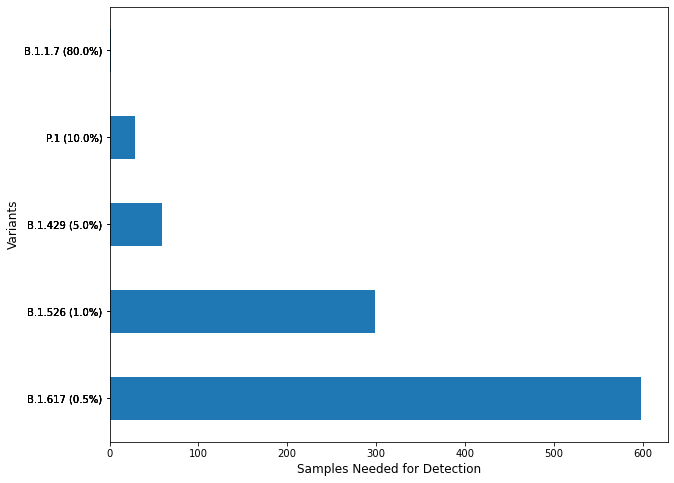

In [79]:
fig, ax = plt.subplots(figsize=(10,8))
variant_df.plot(x="variant", y="detection_samples", kind="barh", ax=ax, legend=None)
ax.set_yticklabels([i.get_text() + f" ({variant_prevalences[i.get_text()]*100}%)" for i in ax.get_yticklabels()])
ax.set_ylabel("Variants", fontsize=12)
ax.set_xlabel("Samples Needed for Detection", fontsize=12)

Text(0.5, 0, 'Samples Needed to Estimate Prevalence')

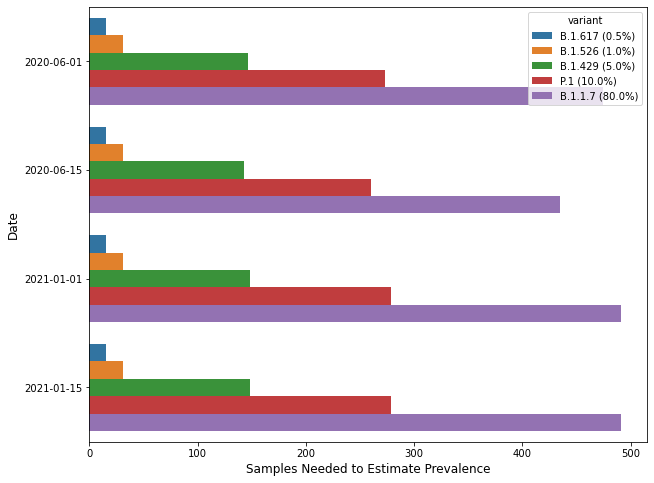

In [88]:
fig, ax = plt.subplots(figsize=(10,8))
variant_df.date = variant_df.date.astype(str)
# variant_df.variant = variant_df.variant.apply(lambda row: row + f" ({variant_prevalences[row]*100}%)")
sns.barplot(x="estimate_samples", y="date", hue="variant", data=variant_df)
# variant_df.plot(x="variant", y="detection_samples", kind="barh", ax=ax, legend=None)
# ax.set_yticklabels([i.get_text() + f" ({variant_prevalences[i.get_text()]*100}%)" for i in ax.get_yticklabels()])
ax.set_ylabel("Date", fontsize=12)
ax.set_xlabel("Samples Needed to Estimate Prevalence", fontsize=12)

,location,date,variant,prevalence,detection_samples,estimate_samples,confidence,CI_tail
0,51059,2020-06-01,B.1.617,0.005,598,15.575379,0.95,0.05
5,51059,2020-06-15,B.1.617,0.005,598,15.532002,0.95,0.05
10,51059,2021-01-01,B.1.617,0.005,598,15.591383,0.95,0.05
15,51059,2021-01-15,B.1.617,0.005,598,15.591359,0.95,0.05


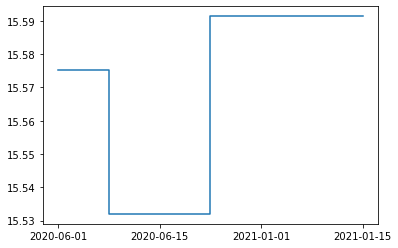

In [32]:
fig, ax = plt.subplots()
for ix, variant in enumerate(variant_df.variant.unique()):
    df = variant_df[variant_df.variant == variant]
    break
ax.step(df.date.astype(str), df.estimate_samples, where="mid")
df

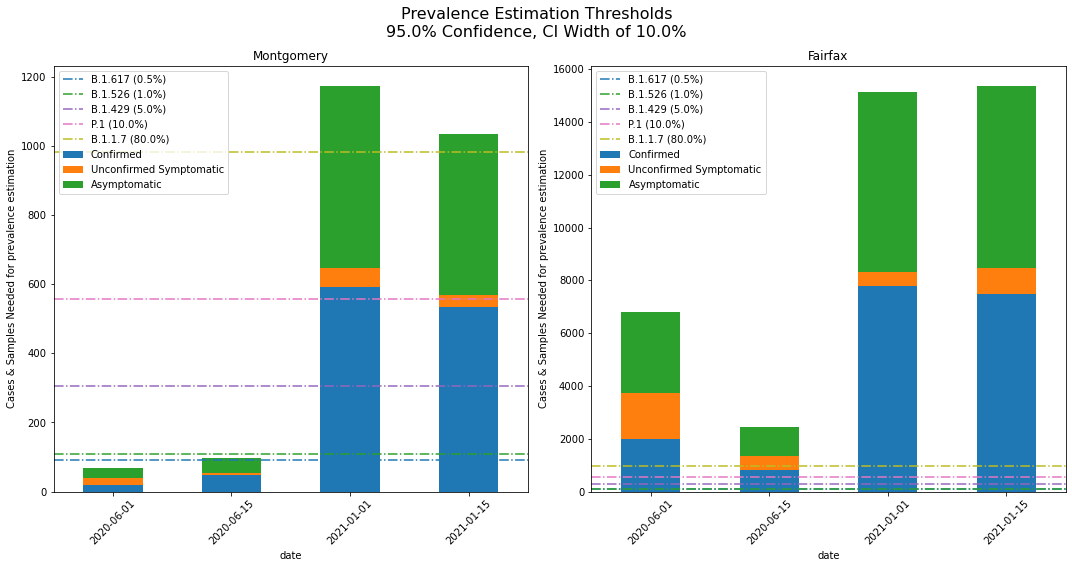